In [136]:
!pip install torchinfo
!pip install hiddenlayer
!pip install torchviz
!pip install netron
!pip install onnx onnxruntime onnxscript netron



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 18.1 MB/s eta 0:00:0031m18.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 15.4 MB/s eta 0:00:00 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.0/683.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.9/676.9 kB 7.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [150]:
import torch
import torch.nn as nn 
from torchviz import make_dot
from IPython.display import display
from graphviz import Source , Digraph
import netron

In [151]:
import torch
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, in1, in2, in3):
        super(Model, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Linear(in1, 4),
            nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Linear(in2, 4),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Linear(in3, 4),
            nn.ReLU()
        )

        self.final_hidden = nn.Sequential(
            nn.Linear(4*3, 2),
            nn.ReLU(),
            nn.Linear(5, 3),
            nn.ReLU(),
            nn.Linear(4, 2),
            nn.ReLU()
        )

        self.final = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, f1, f2, f3):
        out1 = self.branch1(f1)
        out2 = self.branch2(f2)
        out3 = self.branch3(f3)
        combined = torch.cat([out1, out2, out3], dim=1)
        x = self.final_hidden(combined)
        return self.sigmoid(self.final(x))


In [152]:
f1 = torch.rand(1,5)
f2 = torch.rand(1,5)
f3 = torch.rand(1,6)

model = Model(f1.shape[1], f2.shape[1], f3.shape[1])

torch.onnx.export(
    model,
    (f1, f2, f3),
    "model.onnx",
    input_names=["f1","f2","f3"],
    output_names=["output"],
    opset_version=16
)

# Launch Netron
netron.start("model.onnx")


W1210 15:20:28.897000 3289 site-packages/torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 16 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features
E1210 15:20:29.248000 3289 site-packages/torch/_subclasses/fake_tensor.py:2759] failed while attempting to run meta for aten.mm.default
E1210 15:20:29.248000 3289 site-packages/torch/_subclasses/fake_tensor.py:2759] Traceback (most recent call last):
E1210 15:20:29.248000 3289 site-packages/torch/_subclasses/fake_tensor.py:2759]   File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/_subclasses/fake_tensor.py", line 2755, in _dispatch

[torch.onnx] Obtain model graph for `Model([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Model([...]` with `torch.export.export(..., strict=False)`... ❌
[torch.onnx] Obtain model graph for `Model([...]` with `torch.export.export(..., strict=True)`...
[torch.onnx] Obtain model graph for `Model([...]` with `torch.export.export(..., strict=True)`... ❌


TorchExportError: Failed to export the model with torch.export. [96mThis is step 1/3[0m of exporting the model to ONNX. Next steps:
- Modify the model code for `torch.export.export` to succeed. Refer to https://pytorch.org/docs/stable/generated/exportdb/index.html for more information.
- Debug `torch.export.export` and submit a PR to PyTorch.
- Create an issue in the PyTorch GitHub repository against the [96m*torch.export*[0m component and attach the full error stack as well as reproduction scripts.

## Exception summary

<class 'RuntimeError'>: a and b must have same reduction dim, but got [1, 6] X [12, 3].

(Refer to the full stack trace above for more information.)

In [119]:
model.final.bias

Parameter containing:
tensor([-0.5150], requires_grad=True)

In [120]:
model.final.weight

Parameter containing:
tensor([[-0.5105,  0.0711, -0.5017]], requires_grad=True)

In [121]:
summary(
    model,
    input_data=(
        torch.rand(10, f1.shape[1]),
        torch.rand(10, f2.shape[1]),
        torch.rand(10, f3.shape[1])
    )
)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [10, 1]                   --
├─Sequential: 1-1                        [10, 4]                   --
│    └─Linear: 2-1                       [10, 4]                   24
│    └─ReLU: 2-2                         [10, 4]                   --
├─Sequential: 1-2                        [10, 4]                   --
│    └─Linear: 2-3                       [10, 4]                   24
│    └─ReLU: 2-4                         [10, 4]                   --
├─Sequential: 1-3                        [10, 4]                   --
│    └─Linear: 2-5                       [10, 4]                   28
│    └─ReLU: 2-6                         [10, 4]                   --
├─Sequential: 1-4                        [10, 3]                   --
│    └─Linear: 2-7                       [10, 5]                   65
│    └─ReLU: 2-8                         [10, 5]                   --
│    └─Linear: 

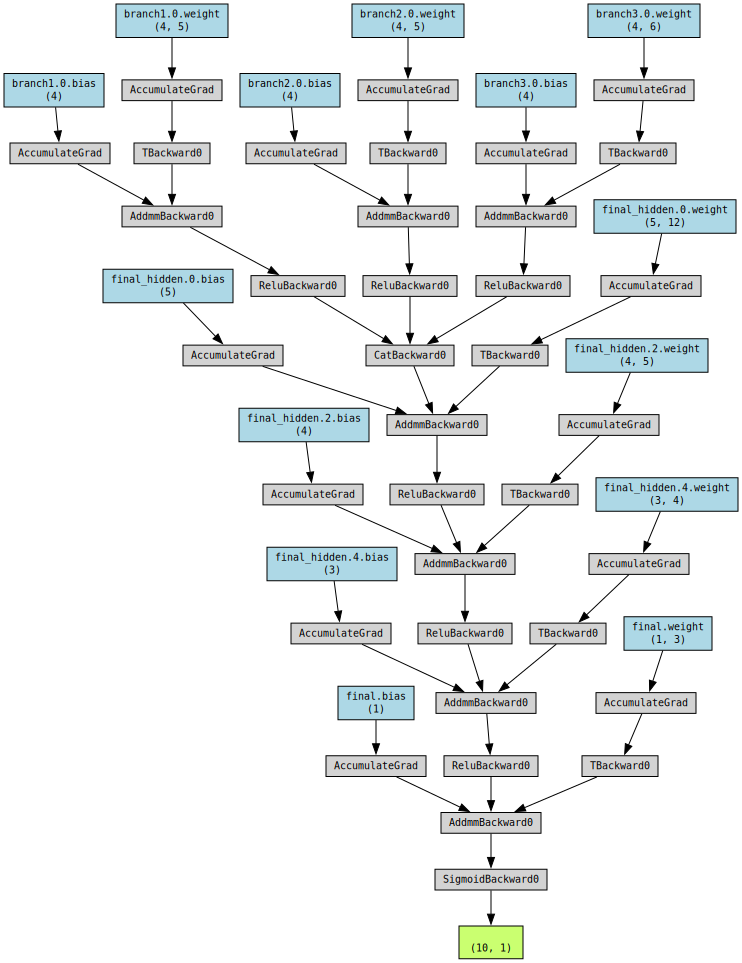

In [122]:
dot = make_dot(y, params=dict(model.named_parameters()))
display(Source(dot.source))